<a href="https://colab.research.google.com/github/PragyaKumari2203/Image-Captioning-Model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-requisites and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Image-Captioning-Model

Mounted at /content/drive
/content/drive/MyDrive/Image-Captioning-Model


In [2]:
import os
import string
import nltk
import numpy as np
import torch
from collections import defaultdict, Counter
from torchvision import transforms, models
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import heapq
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# **Data Preparation**




In [4]:
PATH_TO_CAPTIONS = "./Flickr8K/Flickr8k_text/Flickr8k.token.txt"
PATH_TO_IMAGES = "./Flickr8K/Flickr8k_Dataset"
PATH_TO_TRAINING_DATA = "./Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt"
PATH_TO_VALID_DATA = "./Flickr8K/Flickr8k_text/Flickr_8k.devImages.txt"
PATH_TO_TEST_DATA = "./Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt"
PATH_TO_GLOVE = "./glove.6B/glove.6B.300d.txt"

## Utility functions



In [5]:
def load_captions(filepath):
  with open(filepath,'r') as f:
    lines = f.readlines()
  captions = defaultdict(list)
  for line in lines:
    img_id, caption = line.strip().split('\t')
    img_id = img_id[:-2]
    tokens = nltk.word_tokenize(caption.lower())
    tokens = [word for word in tokens if word not in string.punctuation]
    cleaned_caption = ' '.join(tokens)
    captions[img_id].append(cleaned_caption)
  return captions


def image_transforms():
  return transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
  ])


def load_image_list(filepath):
  with open(filepath,'r') as f:
    return [line.strip() for line in f.readlines()]


def collate_fn(batch):
  images, captions = zip(*batch)
  images = torch.stack(images, dim=0)
  padded_captions = pad_sequence(captions, batch_first=True, padding_value=0)
  lengths = [len(caps) for caps in captions]
  return images, padded_captions, lengths

## Vocabulary Creation

In [6]:
class Vocabulary:
  def __init__(self,freq_threshold):
    self.freq_threshold = freq_threshold
    self.idx2word = {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '<unk>'}
    self.word2idx = {v:k for k, v in self.idx2word.items()}
    self.embeddings = None
    self.word_freq = Counter()
    self.idx = 4


  def __len__(self):
    return len(self.word2idx)


  def build_vocab(self,captions_dict):
    for _, captions in captions_dict.items():
      for caption in captions:
        self.word_freq.update(caption.split())
    for word,freq in self.word_freq.items():
      if freq >= self.freq_threshold:
        self.idx2word[self.idx] = word
        self.word2idx[word] = self.idx
        self.idx += 1


  def numericalize(self, text):
    tokens = text.split()
    return [self.word2idx.get(token, self.word2idx['<unk>']) for token in tokens]


  def load_glove(self, glovepath, dim = 300):
    embedding_index = {}
    with open(glovepath, 'r', encoding='utf-8') as f:
      for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],dtype='float32')
        embedding_index[word] = vector
    vocab_size = len(self.word2idx)
    embedding_matrix = np.zeros((vocab_size, dim))
    for word, idx in self.word2idx.items():
      if word in embedding_index:
        embedding_matrix[idx] = embedding_index[word]
      else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(dim,))
    self.embeddings = torch.tensor(embedding_matrix, dtype=torch.float32)

## Custom Dataset

In [7]:
class Flickr8k_Dataset(Dataset):
  def __init__(self, image_dir, image_list, captions_dict, vocab, transform=None):
    self.image_dir = image_dir
    self.image_list = image_list
    self.captions_dict = captions_dict
    self.vocab = vocab
    self.transform = transform

    self.image_captions_pairs = []
    for img_id in self.image_list:
      for caption in self.captions_dict[img_id]:
        self.image_captions_pairs.append((img_id, caption))


  def __len__(self):
    return len(self.image_captions_pairs)


  def __getitem__(self, idx):
    img_id, caption = self.image_captions_pairs[idx]
    img_path = os.path.join(self.image_dir, img_id)
    image = Image.open(img_path).convert('RGB')
    if self.transform is not None:
      image = self.transform(image)
    numericalized = [self.vocab.word2idx['<sos>']] + self.vocab.numericalize(caption) + [self.vocab.word2idx['<eos>']]
    return image, torch.tensor(numericalized)

## Putting it All Together


In [8]:
training_data = load_image_list(PATH_TO_TRAINING_DATA)
valid_data = load_image_list(PATH_TO_VALID_DATA)
test_data = load_image_list(PATH_TO_TEST_DATA)

print(f"Number of training images: {len(training_data)}")
print(f"Number of validation images: {len(valid_data)}")
print(f"Number of test images: {len(test_data)}")

Number of training images: 6000
Number of validation images: 1000
Number of test images: 1000


In [9]:
captions_dict = load_captions(PATH_TO_CAPTIONS)

vocab = Vocabulary(freq_threshold=5)
vocab.build_vocab(captions_dict)
vocab.load_glove(PATH_TO_GLOVE)

In [10]:
training_dataset = Flickr8k_Dataset(PATH_TO_IMAGES, training_data, captions_dict, vocab, transform=image_transforms())
valid_dataset = Flickr8k_Dataset(PATH_TO_IMAGES, valid_data, captions_dict, vocab, transform=image_transforms())
test_dataset = Flickr8k_Dataset(PATH_TO_IMAGES, test_data, captions_dict, vocab, transform=image_transforms())

In [11]:
train_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [12]:
for images, captions, lengths in train_dataloader:
    print(f"Images shape: {images.shape}")
    print(f"Captions shape: {captions.shape}")
    print(f"Lengths: {lengths}")
    break

Images shape: torch.Size([32, 3, 224, 224])
Captions shape: torch.Size([32, 26])
Lengths: [11, 10, 16, 12, 13, 8, 11, 10, 13, 10, 10, 14, 11, 13, 9, 14, 11, 13, 14, 10, 14, 13, 14, 9, 14, 15, 13, 8, 10, 10, 26, 17]


In [13]:
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(valid_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")

Number of training batches: 938
Number of validation batches: 157
Number of test batches: 157


## Visualization

In [14]:
example_dataset = Flickr8k_Dataset(PATH_TO_IMAGES, test_data, captions_dict, vocab)

In [15]:
def visualize_random_samples(dataset, vocab):
      img, cap_tensor = random.choice(dataset)
      caption = ' '.join([vocab.idx2word[idx.item()] for idx in cap_tensor])
      if isinstance(img, torch.Tensor):
          img = transforms.ToPILImage()(img)
      plt.imshow(img)
      plt.title(caption)
      plt.axis('off')
      plt.show()

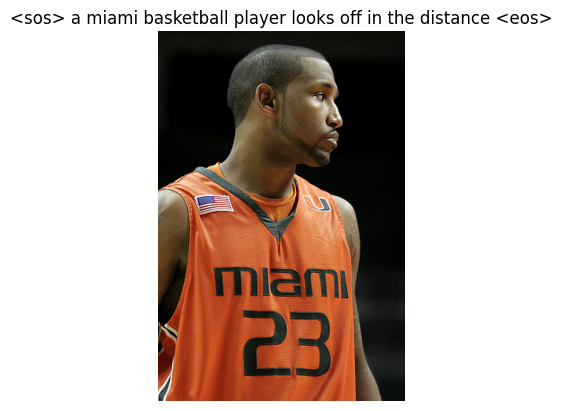

In [18]:
# Note - Image is not transformed.
visualize_random_samples(example_dataset, vocab)

# Model Definition

## Feature Extractor (VGG16)

In [19]:
class VGG16Encoder(nn.Module):
  def __init__(self):
    super(VGG16Encoder, self).__init__()
    vgg = models.vgg16(pretrained=True)
    self.features = vgg.features
    self.avgpool = vgg.avgpool
    self.fc = nn.Sequential(*list(vgg.classifier.children())[:-1])

    for params in self.parameters():
      params.requires_grad = False


  def forward(self,images):
    # images = [batch_size,3,224,224]

    x = self.features(images)
    x = self.avgpool(x)
    x = torch.flatten(x,1)
    x = self.fc(x)

    # x (output) = [batch_size,4096]
    return x

## Decoder (LSTM)

In [20]:
class Decoder(nn.Module):
  def __init__(self, embed_dim, hidden_size, vocab, num_layers = 1):
    super(Decoder,self).__init__()
    self.vocab = vocab
    self.vocab_size = len(self.vocab)
    self.embed = nn.Embedding(self.vocab_size, embed_dim)
    self.embed_weights = nn.Parameter(vocab.embeddings, requires_grad=False)
    self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, self.vocab_size)
    self.img_fc = nn.Linear(4096, embed_dim)


  def forward(self, img_features, captions, lengths):
    # img_features = [batch_size, 4096]
    # captions = [batch_size, seq_len]

    embeddings = self.embed(captions)
    img_embeds = self.img_fc(img_features).unsqueeze(1)
    embeddings = torch.cat((img_embeds, embeddings), dim=1)
    packed = nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
    hiddens, _ = self.lstm(packed)
    outputs = self.linear(hiddens[0])

    # outputs = [total_timesteps, vocab_size]
    return outputs

## Combined Model

In [21]:
class ImageCaptioningModel(nn.Module):
  def __init__(self, encoder, decoder):
    super(ImageCaptioningModel, self).__init__()
    self.encoder = encoder
    self.decoder = decoder


  def forward(self, images, captions, lengths):
    # images = [batch_size, 3, 224, 224]
    # captions = [batch_size, seq_length]
    # lengths = batch_size

    img_features = self.encoder(images)
    outputs = self.decoder(img_features, captions, lengths)

    # outputs = [total_timesteps, vocab_size]
    return outputs

# Training the  model

## Model Initialization

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_dim = 300
hidden_size = 512
num_layers = 1
learning_rate = 0.001

In [ ]:
encoder = VGG16Encoder().to(device)
decoder = Decoder(embed_dim, hidden_size, vocab, num_layers).to(device)
model = ImageCaptioningModel(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 5,331,107 trainable parameters


In [25]:
def trainable_params(model):
    print("Trainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

trainable_params(model)

Trainable parameters:
decoder.embed.weight
decoder.lstm.weight_ih_l0
decoder.lstm.weight_hh_l0
decoder.lstm.bias_ih_l0
decoder.lstm.bias_hh_l0
decoder.linear.weight
decoder.linear.bias
decoder.img_fc.weight
decoder.img_fc.bias


## Training and Evaluation Loops

In [26]:
def train_fn(model, dataloader, optimizer, criterion, device, num_epochs = 10):
  model.train()
  total_loss = 0.0

  for images, captions,lengths in dataloader:
    images, captions = images.to(device), captions.to(device)
    targets = pack_padded_sequence(captions, lengths, batch_first=True, enforce_sorted=False)[0]
    outputs = model(images, captions, lengths)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(dataloader)

def evaluation_fn(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, captions, lengths in dataloader:
            images, captions = images.to(device), captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True, enforce_sorted=False)[0]
            outputs = model(images, captions, lengths)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(dataloader)

## Sampling

In [27]:
def beam_search(model, image, vocab, beam_size=3, max_len=20):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        features = model.encoder(image)
        features = model.decoder.img_fc(features)

        sequences = [[list(), 0.0, (None, None)]]

        for _ in range(max_len):
            all_candidates = []
            for seq, score, (h, c) in sequences:
                if len(seq) > 0 and seq[-1] == vocab.word2idx['<eos>']:
                    all_candidates.append((seq, score, (h, c)))
                    continue

                input_seq = torch.tensor([seq[-1]] if seq else [vocab.word2idx['<sos>']]).to(device)
                embedded = model.decoder.embed(input_seq).unsqueeze(1)

                if len(seq) == 0:
                    embedded = features.unsqueeze(1)

                output, (h, c) = model.decoder.lstm(embedded, (h, c) if h is not None else None)
                scores = model.decoder.linear(output.squeeze(1))
                log_probs = torch.log_softmax(scores, dim=1)

                top_k_probs, top_k_idx = torch.topk(log_probs, beam_size)

                for i in range(beam_size):
                    candidate = seq + [top_k_idx[0][i].item()]
                    candidate_score = score + top_k_probs[0][i].item()
                    all_candidates.append((candidate, candidate_score, (h, c)))

            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = ordered[:beam_size]

        final_seq = sequences[0][0]
        caption = [vocab.idx2word[idx] for idx in final_seq if idx not in [vocab.word2idx['<sos>'], vocab.word2idx['<eos>'], vocab.word2idx['<pad>']]]
        return ' '.join(caption)

In [28]:
def generate_caption(model, image_path, vocab, beam_size=3, max_len=20):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = image_transforms()
    image = transform(image).unsqueeze(0).to(device)

    caption = beam_search(model, image[0], vocab, beam_size, max_len)
    return caption

## Training the model

In [30]:
best_val_loss = float('inf')
if os.path.exists("saved_model.pth"):
  model.load_state_dict(torch.load("saved_model.pth"))
  print("Loaded saved model from checkpoint!")
  best_val_loss = evaluation_fn(model, valid_dataloader, criterion, device)
  print(f"Best validation loss so far: {best_val_loss}")

Loaded saved model from checkpoint!
Best validation loss so far: 2.684208825135687


In [33]:
start_epoch = 4
if start_epoch != 0:
      print(f"Resuming training from epoch {start_epoch}...")

for epoch in range(start_epoch, 10):
    train_loss = train_fn(model, train_dataloader, optimizer, criterion, device)
    val_loss = evaluation_fn(model, valid_dataloader, criterion, device)

    print(f"Epoch {start_epoch+1}/{10}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), "saved_model.pth")
      print("Saved new best model")

    # Test generation
    test_image = random.choice(test_data)
    test_path = os.path.join(PATH_TO_IMAGES, test_image)
    caption = generate_caption(model, test_path, vocab)
    print(f"Sample Generation: {caption}\n")

Resuming training from epoch 4...
Epoch 5/10
Train Loss: 2.0996 | Val Loss: 2.7018
Sample Generation: a man and a woman are walking past a building

Epoch 5/10
Train Loss: 1.9096 | Val Loss: 2.7338
Sample Generation: a man in a white shirt and tie is wearing a mask

Epoch 5/10
Train Loss: 1.7634 | Val Loss: 2.7855
Sample Generation: a group of people are standing in front of some stores

Epoch 5/10
Train Loss: 1.6336 | Val Loss: 2.8505
Sample Generation: a black and white dog is running on the grass

Epoch 5/10
Train Loss: 1.5188 | Val Loss: 2.9172
Sample Generation: a young girl in a bathing suit getting splashed in water

Epoch 5/10
Train Loss: 1.4166 | Val Loss: 2.9847
Sample Generation: a man in a wetsuit surfing



# Inference

In [ ]:
model.load_state_dict(torch.load("saved_model.pth"))
test_loss = evaluation_fn(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.3f}")

In [39]:
def display_captioned_images(model, test_data, vocab, path_to_images, num_images=9, cols=3):
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(5 * cols, 5 * rows))

    for i in range(num_images):
        test_image = random.choice(test_data)
        test_image_path = os.path.join(path_to_images, test_image)

        caption = generate_caption(model, test_image_path, vocab)
        image = Image.open(test_image_path)

        max_words_per_line = 5
        caption_words = caption.split()
        wrapped_caption = '\n'.join([' '.join(caption_words[j:j + max_words_per_line])
                                     for j in range(0, len(caption_words), max_words_per_line)])

        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(wrapped_caption, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_captioned_images(model, test_data, vocab, PATH_TO_IMAGES)

Output hidden; open in https://colab.research.google.com to view.